### Notebook setup

#### Import shunpiker pre-set packages and modules
 
For an introduction to python packages and modules, see https://realpython.com/python-modules-packages/#python-packages.    

In [1]:
# import shunpiker pre-set packages and modules
%run shunpiker_modules.py

scanpy==1.8.2 anndata==0.7.6 umap==0.5.2 numpy==1.20.3 scipy==1.7.1 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.13.0 python-igraph==0.9.8 pynndescent==0.5.5
phenograph== 1.5.7


💡 **Hint:** Use the code below ONLY if you need to install extra packages

In [2]:
#import sys
#!{sys.executable} -m pip install scrublet

#### Set notebook parameters

[`%matplotlib inline`](https://ipython.readthedocs.io/en/stable/interactive/tutorial.html#magics-explained) sets output of plotting commands to be displayed directly below the code cell that produced it.


<a id='part_1'></a>

In [3]:
# display plot directly below code cell
%matplotlib inline

## Sample "clean-up"

### Read in scRNA-seq raw counts into a python object

❗ Choose between [cellranger](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/output/overview) and [SEQC](https://github.com/dpeerlab/seqc) data format for your input

Both data inputs will be converted into a scRNA-seq friendly python object called an AnnData object. The AnnData object is  is made up of several components. For a more detailed explanation, see https://anndata.readthedocs.io/en/latest/anndata.AnnData.html#anndata.AnnData. 

Once you execute either of the input commands below, you should be able to access:
- counts: `adata.X` + Run
- gene names: `adata.var` + Run
- cell index and other annotation: `adata.obs` + Run

#### Input SEQC data

🕹️  Provide the path to your raw data and the name of your sample

In [4]:
# type path to your SEQC data folder (replace example path with your path)
path_to_seqc_data = '../data/'

In [5]:
# type name of your file (replace example file name with your file name)
sample_name = '3003_Vd2_patients_IGO_12381_54_dense.csv'

In [6]:
# convert your selected sample/samples into one anndata object  
adata = import_seqc_data(path_to_seqc_data, sample_name)
adata.X = np.array(pd.DataFrame(adata.X).fillna(0)) # fill NAs with 0s

In [7]:
# randomize the order of cells for plotting
np.random.seed(42) 
index_list = np.arange(adata.shape[0])
np.random.shuffle(index_list)
adata = adata[index_list]

❗Using the line below you can check the number of cells (x, ) and genes ( ,y) that you have in your sample. 

This is a good sanity check after every filtering step to make sure the filters have been applied properly.

### Calculate quality control metrics for your sample before preprocessing

To start, we will calculate some standard quality control (QC) metrics using the `calc_QC_metrics()` function that is defined within the `shunpiker_modules.py` file. The QC metrics calculated include total counts, number of genes, and ribosomal and mitochondrial fraction on a per cell basis.

In [8]:
# caclutate QC metrics for your sample
calc_QC_metrics(adata)

Trying to set attribute `.obs` of view, copying.


❗To check if the QC metrics are now available for your sample, you can run the command below and inspect the column names.

In [9]:
# show top 5 rows from sample metadata (stored in adata.obs)
adata.obs.head()

n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
cell_barcodes                                                               
239586896374558               1727                 7.454720        4545.0   
122369603230492                496                 6.208590        1076.0   
236845364362462               1073                 6.979145        2944.0   
195418284748022               1744                 7.464510        5208.0   
160301814770547               1612                 7.385851        5028.0   

                 log1p_total_counts  pct_counts_in_top_50_genes  \
cell_barcodes                                                     
239586896374558            8.422003                   37.293729   
122369603230492            6.981935                   54.368030   
236845364362462            7.987864                   35.733696   
195418284748022            8.558144                   37.884025   
160301814770547            8.522977                   39.598250   

                 pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
cell_barcodes                                                               
239586896374558                    48.646865                    58.129813   
122369603230492                    63.197026                    72.490706   
236845364362462                    51.019022                    64.538043   
195418284748022                    49.846390                    59.850230   
160301814770547                    53.202068                    63.464598   

                 pct_counts_in_top_500_genes  original_total_counts  \
cell_barcodes                                                         
239586896374558                    72.541254                 4545.0   
122369603230492                   100.000000                 1076.0   
236845364362462                    80.536685                 2944.0   
195418284748022                    73.598310                 5208.0   
160301814770547                    77.147971                 5028.0   

                 log10_original_total_counts  mito_frac  RBP_frac  
cell_barcodes                                                      
239586896374558                     3.657534   0.023542  0.296810  
122369603230492                     3.031812   0.189591  0.056691  
236845364362462                     3.468938   0.039742  0.342391  
195418284748022                     3.716671   0.051459  0.299539  
160301814770547                     3.701395   0.061854  0.338504

### Data "clean-up": identification of doublet cells

We will use the scanpy implementation ([`scanpy.external.pp.scrublet`](https://scanpy.readthedocs.io/en/latest/generated/scanpy.external.pp.scrublet.html#scanpy-external-pp-scrublet)) of the [scrublet package](https://github.com/swolock/scrublet) to identify doublet cells. This command will use the default parameters of `scanpy.external.pp.scrublet`, however, if you are feeling brave or disagree with the predicted doublets you can use this [example notebook](https://github.com/swolock/scrublet/blob/master/examples/scrublet_basics.ipynb) to alter any of these parameters.

In [10]:
# run scanpy implementation of the scrublet package to identify doublet cells
sc.external.pp.scrublet(adata)

/home/kousaa/miniconda3/envs/AK011_py38/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.71
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


### Data "clean-up": removal of not expressed genes

Genes with zero counts across all cells will not provide any biological insight, but rather delay some of the downstream processing steps, thus we choose to remove genes that are not expressed in any cells. You can make this step more stringend by asking genes to be expressed in at least N number of cells.

In [11]:
# remove genes that are not expressed in any cells (remove columns with all 0s)
sc.pp.filter_genes(adata, min_cells=1)

In [12]:
adata.shape

(18180, 18260)

### Data "clean-up": removal of rRNA

Ribosomal protein (RBP) RNA often constitutes between 20-50% of your counts. Variation in their expression can therefore highly affect the outcome of your visualization algorithms and differential gene expression analyses. Our experience is that expression levels of RBP RNA often cannot be reproduced or validated, and are moreover difficult to interpret. One can therefore decide to remove these genes from the data altogether.

In [13]:
adata = remove_RBs(adata)

### Data "clean-up": data normalization

RNA counts generally vary linearly with library size: RNA molecules have a steady concentration rather than a steady absolute number (Additional variation suggests biological variation in gene expression among your cells). Therefore, it is usually appropriate to normalize each cell to the same total library size, thereby converting RNA counts to a relative rather than absolute count. Below a random gene is plotted against library size to show that expression, at least if not variable between cell types in your sample, changes according to library size. We take a gene with a minimum gene expression of 1, because trends in genes with low mean expression are occluded by noise. Run the cell below a few times to inspect the general trend between gene expression and library size. Note that scRNA-seq data is highly noisy, and the correlation will therefore be noisy as well in genes with lower expression.

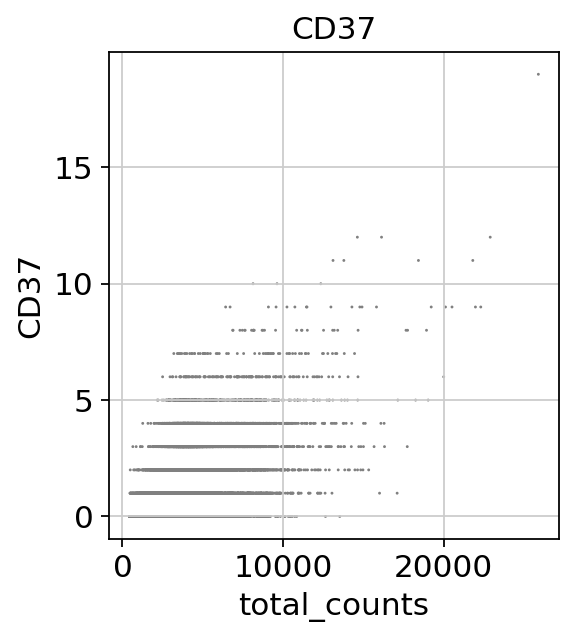

In [14]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
observe_library_size_effect(adata)

An alternative method to normalize data is using SCRAN that applies a similar principle to common normalization methods in bulk RNA data.

Here we will normalize to a total library size of 10,000. Scanpy will update our count matrix (adata.X) automatically with the normalized counts.

In [15]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=10**4)

Trying to set attribute `.obs` of view, copying.


### Data "clean-up": log-transformation

Log transformation makes changes in expression relative rather than absolute (e.g. it looks at doubling (when using log2) of expression rather than increase of n counts in expression). It makes the differences between highly and lowly expressed genes smaller, and limits the effects of highly expressed genes on your data analysis. It is often considered a default part of preprocessing, but can occasionally be better left out. The desired effect of a log-transformation is that it brings out biological differences between your cell populations better. <br>
Scanpy's log transformation function takes the natural logarithm of each (count + 1), and updates your count matrix (adata.X): 

In [16]:
sc.pp.log1p(adata)

### Let's have a look at our data

UMAP embedding gives us a two-dimensional representation of our data, based on the similarities/differences among the cells in a higher-dimensional space. Each type of mapping has its own strenghts and weaknesses, thus it can be useful to take a look at different mappings. Using a selection of principal components before UMAP will not only shorten computation time, but also reduces noise.

In [17]:
rng = np.random.RandomState(42)
adata = sc.tl.pca(adata, n_comps=200, copy = True, svd_solver='arpack', random_state=rng)

We can visualize the percentage of variance explained by each PC. Based on this figure, we will select a number of principal components to use in the rest of our analysis. 

<function matplotlib.pyplot.show(close=None, block=None)>

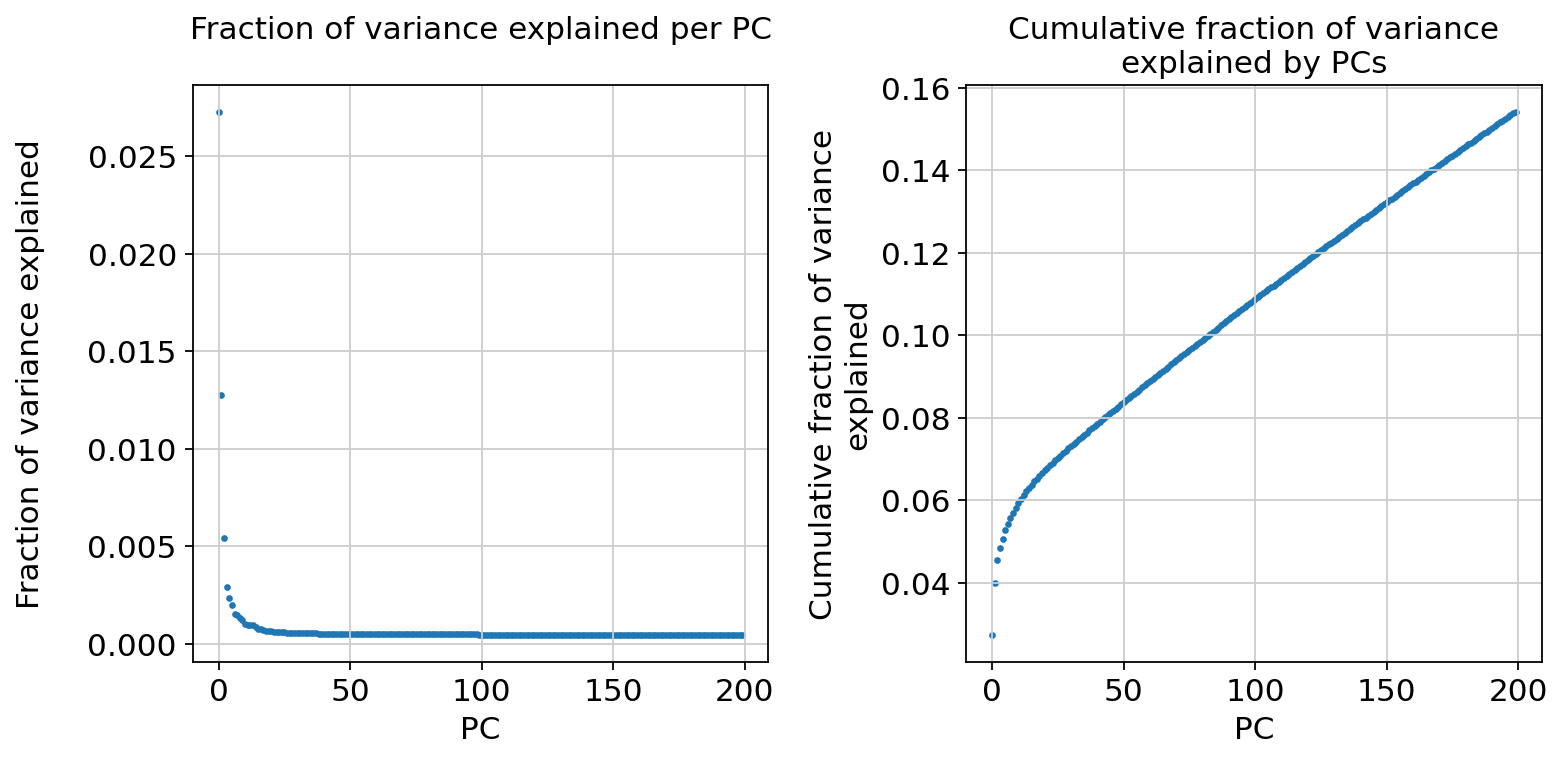

In [18]:
observe_variance(adata)

❗ We want to include all the principal components before the 'knee point' (the point where the fitted curve would change slope the most), because these likely represent important sources of variance in our data. To try to avoid eliminating any relevant but small sources of variance, we will choose a number of PCs slightly to the right of the knee point. 

🕹️  Replace the number below with your selection and run PCA again.

In [23]:
rng = np.random.RandomState(42)
sc.tl.pca(adata, n_comps=20, svd_solver='arpack', random_state=rng)

We will now run UMAP. When dealing with a very large dataset, it might be useful to use a perplexity higher than the default (`n_neighbors=15`). The command below will automatically use our PCA as a basis for calculating the embedding.

In [24]:
sc.pp.neighbors(adata, n_neighbors=15)

In [25]:
sc.tl.umap(adata)

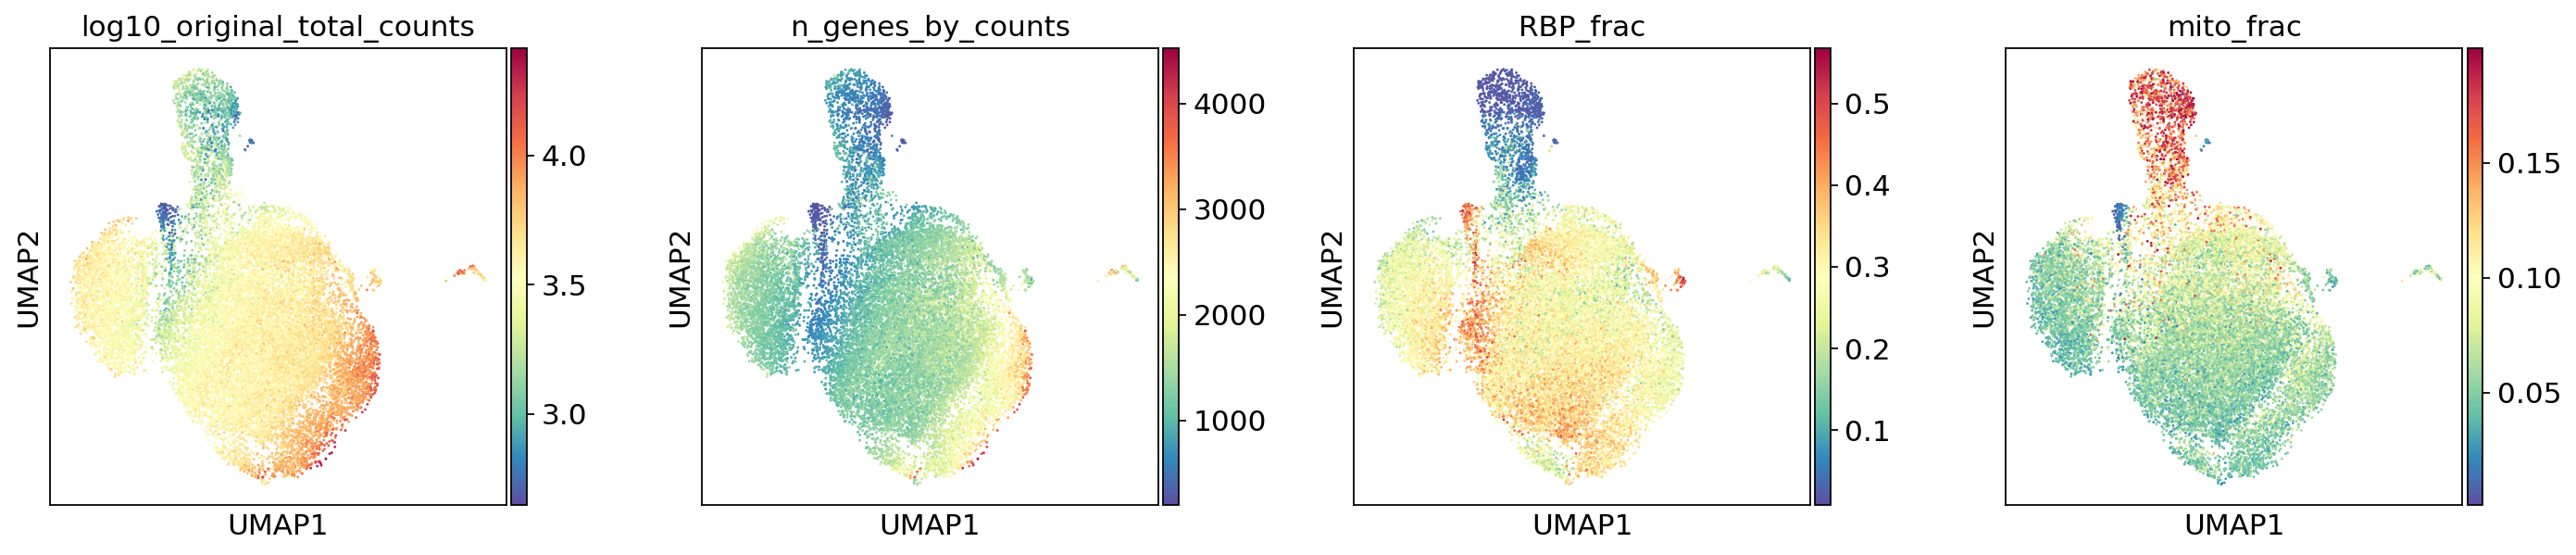

In [26]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
# plot major canonical markers as a sanity check
sc.pl.umap(
    adata, 
    color=['log10_original_total_counts', 'n_genes_by_counts','RBP_frac', 'mito_frac'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

🕹️ Inspect canonical markers of your choice

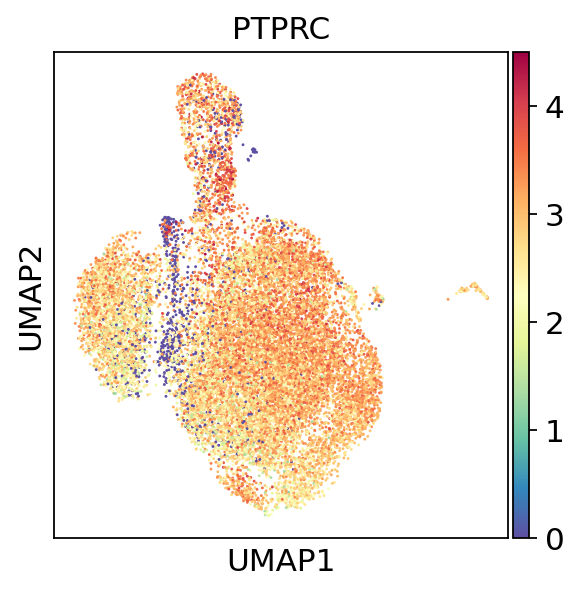

In [27]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
# plot major canonical markers as a sanity check
sc.pl.umap(
    adata, 
    color=['PTPRC'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=5,
    wspace = 0.3,
    sort_order = False
)

❗ **Does your data look well distinguished?** If yes, move ahead. If no, maybe try to increase the number of principal components you used, and rerun the last bits of code.

### Run unsupervised clustering analysis using PhenoGraph

Next, we will filter out cells that we think are either dying cells or empty droplets. Both are characterized by low library size, dying cells additionally have relatively high percentages of mitochondrial RNA. Rather than using cutoffs, we remove cells by cluster. This prevents us from taking out cells that belong to a biologically relevant cluster, despite having e.g. low library size or high mitochrondrial RNA. It furthermore ensures that we take out all cells with a phenotype similar to what we think are cells that should be taken out, even if they happen not to exceed a possible cutoff we would have otherwise chosen. We can furthermore remove clusters that we are not interested in, such as doublets and contaminants.

For clustering, we use [PhenoGraph](https://www.sciencedirect.com/science/article/pii/S0092867415006376). This is a highly robust graph-based clustering algorithm that was designed for single cell data. Your choice of k (number of nearest neighbors to use for graph construction) can affect the number of clusters and their size.

❗ How to select a number for neighbour cells (k) for fairly robust clustering.

Calculate clustering characteristics for a range of ks (5 to 155), by a step of 5.

Inspect the following clustering metrics:
- Minimum number of k for a connected graph.
- Changes in Q-modularity score (see PhenoGraph paper) for different ks. The Q-modularity usually drops quickly in the beginning (due to swiftly increasing connectedness when increasing a low k), and only slightly decreases after a certain point. However, in the case of homogeneous data with little structure, you might see a constant rapid decay in Q score. The plot below is not needed for a good choice of k, but is informative about the modularity of your data.
- Similarity/difference in cluster assignments between the different ks. We will use the Rand index to this end. The Rand index algorithm compares to clusterings by testing for every pair of cells, whether or not they were both clustered together or separately in both clusterings. E.g. if two cells were not in the same cluster in clustering 1, but were clustered together in clustering 2, this will decrease the Rand score. Alternatively, if they were in separate clusters in both cases, or in the same cluster in both cases, this will increase the score. The Rand index ranges from 0 to 1, with 1 indicating identical cluster assignments. We will calculate the Rand indices for all pairs of k and visualize the Rand indices using a heatmap, with our chosen range of k in the rows and columns, and the color indicating similarity in cluster assignments (red=high similarity, blue=low similarity). We can use the heatmap to find a region of ks where the clustering is fairly similar between runs (e.g. an index around 0.8 or higher). Within that 'robust region', we should choose a low k to retain as much resolution as possible.

⏳ This step might take a while so be patient

In [28]:
# calculate clustering characteristics for a range of ks (5 to 155), by a step of 5.
ks = np.arange(5,155,5)
cluster_chars = [calc_clustering_characteristics(k, adata.obsm['X_pca']) for k in ks];

Finding 5 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 7.034130811691284 seconds
Jaccard graph constructed in 11.639639377593994 seconds
Wrote graph to binary file in 0.027889490127563477 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.940127
Louvain completed 21 runs in 7.567859172821045 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 35.941898345947266 seconds
Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 6.622445106506348 seconds
Jaccard graph constructed in 12.1043221950531 seconds
Wrote graph to binary file in 0.0970921516418457 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.859546
After 4 runs, maximum modularity is Q = 0.861317
Louvain completed 24 runs in 10.327135801315308 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 38.90859889984131 seconds
Find

Sorting communities by size, please wait ...
PhenoGraph completed in 145.52175998687744 seconds
Finding 85 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 9.00885796546936 seconds
Jaccard graph constructed in 88.640141248703 seconds
Wrote graph to binary file in 0.8831498622894287 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.784765
Louvain completed 21 runs in 20.404419422149658 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 128.7070939540863 seconds
Finding 90 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 6.995559930801392 seconds
Jaccard graph constructed in 60.429880142211914 seconds
Wrote graph to binary file in 0.9021837711334229 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.77893
After 2 runs, maximum modularity is Q = 0.782557
Louvain completed 22 runs in 25.638997793197632 seconds
Sorting

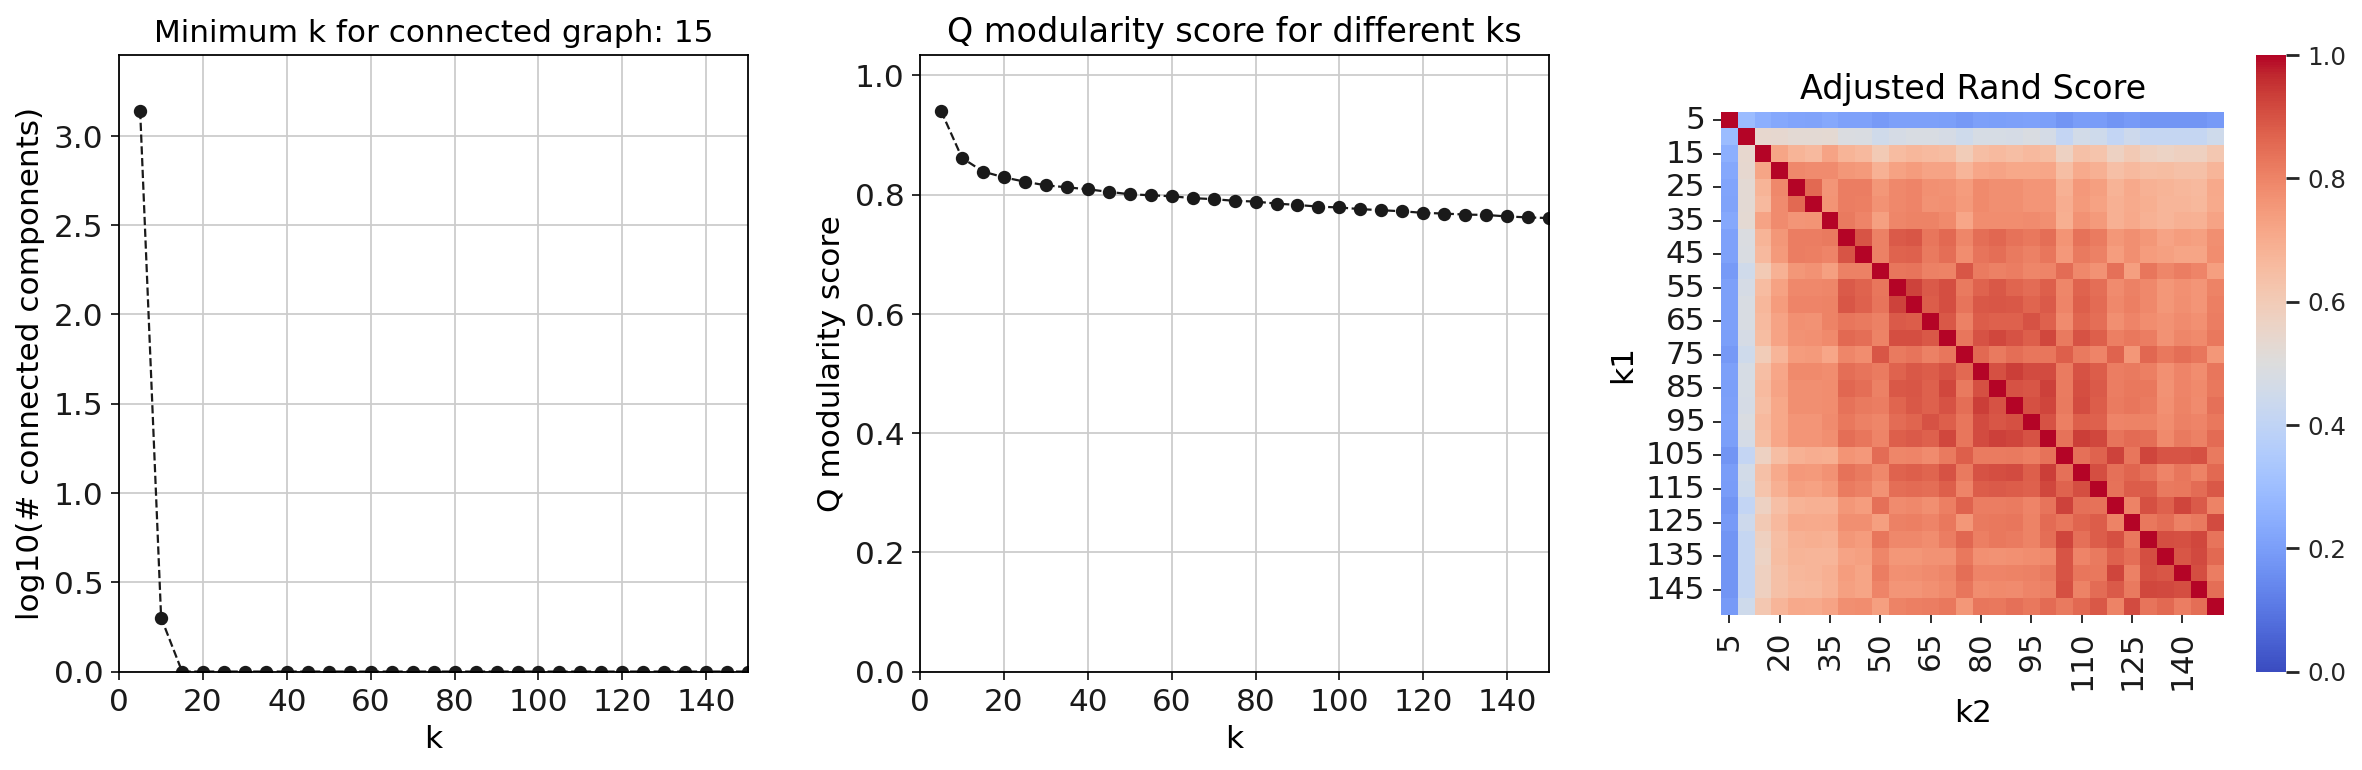

In [29]:
# plot clustering metrics
Rand_index_df = inspect_clustering_chars(ks, cluster_chars)

In [30]:
# print table with rand scores for the different ks
Rand_index_df.iloc[1:10,1:15]

k2        10        15        20        25        30        35        40  \
k1                                                                         
10  1.000000  0.541451  0.536759  0.523539  0.524578  0.528598  0.491918   
15  0.541451  1.000000  0.722440  0.679673  0.662570  0.725665  0.676782   
20  0.536759  0.722440  1.000000  0.791424  0.784645  0.783016  0.755476   
25  0.523539  0.679673  0.791424  1.000000  0.856552  0.760722  0.814373   
30  0.524578  0.662570  0.784645  0.856552  1.000000  0.763122  0.812879   
35  0.528598  0.725665  0.783016  0.760722  0.763122  1.000000  0.824053   
40  0.491918  0.676782  0.755476  0.814373  0.812879  0.824053  1.000000   
45  0.487563  0.663562  0.749129  0.813834  0.810531  0.799850  0.897651   
50  0.453094  0.602948  0.685467  0.757504  0.767032  0.732541  0.805682   

k2        45        50        55        60        65        70        75  
k1                                                                        
10  0.487563  0.453094  0.472231  0.483165  0.481331  0.469974  0.446776  
15  0.663562  0.602948  0.653459  0.668842  0.658722  0.649655  0.596450  
20  0.749129  0.685467  0.730441  0.745775  0.723478  0.722665  0.672171  
25  0.813834  0.757504  0.791630  0.798662  0.770463  0.769479  0.742352  
30  0.810531  0.767032  0.789213  0.797579  0.767120  0.770221  0.749334  
35  0.799850  0.732541  0.794345  0.802141  0.802622  0.788757  0.717474  
40  0.897651  0.805682  0.883459  0.891586  0.831989  0.856932  0.793795  
45  1.000000  0.804832  0.867817  0.874325  0.821928  0.846773  0.778716  
50  0.804832  1.000000  0.828330  0.835517  0.805814  0.804135  0.893490

🕹️ Using the heatmap and table above choose a value for k. 

As rule of thumb, choose a connected graph k with an adjusted Rand score >=0.8 for 4 consecutive steps. 

In [31]:
# run unsupervised clustering analysis with PhenoGraph
k=40 # add your selected k value here
communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata.obsm['X_pca']),k=k)
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 40 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 14.156498193740845 seconds
Jaccard graph constructed in 28.578710079193115 seconds
Wrote graph to binary file in 0.8870217800140381 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.805733
After 2 runs, maximum modularity is Q = 0.807188
After 13 runs, maximum modularity is Q = 0.809659
Louvain completed 33 runs in 47.09081220626831 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 106.82447290420532 seconds


We can visualize the clustering to see which clusters match with the cells that we would like to filter out. Inspect the list of QC metrics and canonical markers to make your choice.

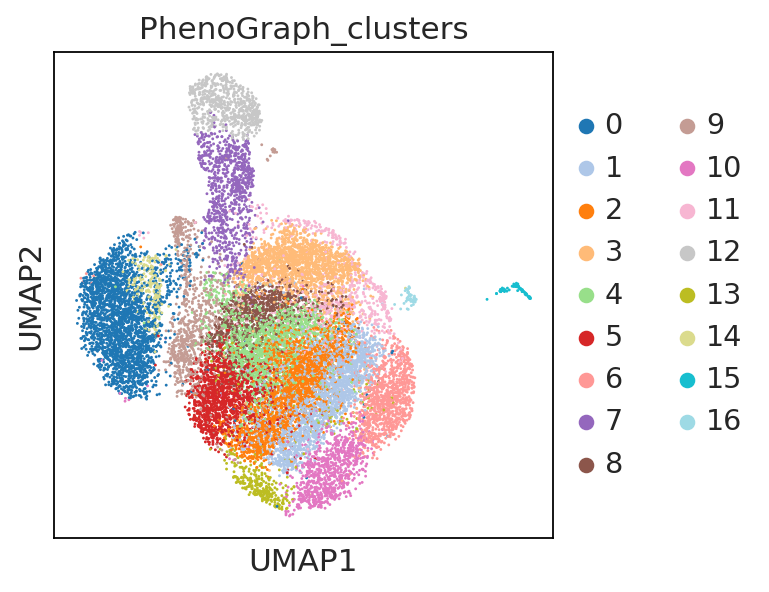

In [32]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.5,
    sort_order = False
)

### Filtering out cells: by cluster

Now inspect tha QC metrics for each of the clusters and choose to remove any clusters that may have a combination of bad quality metrics.

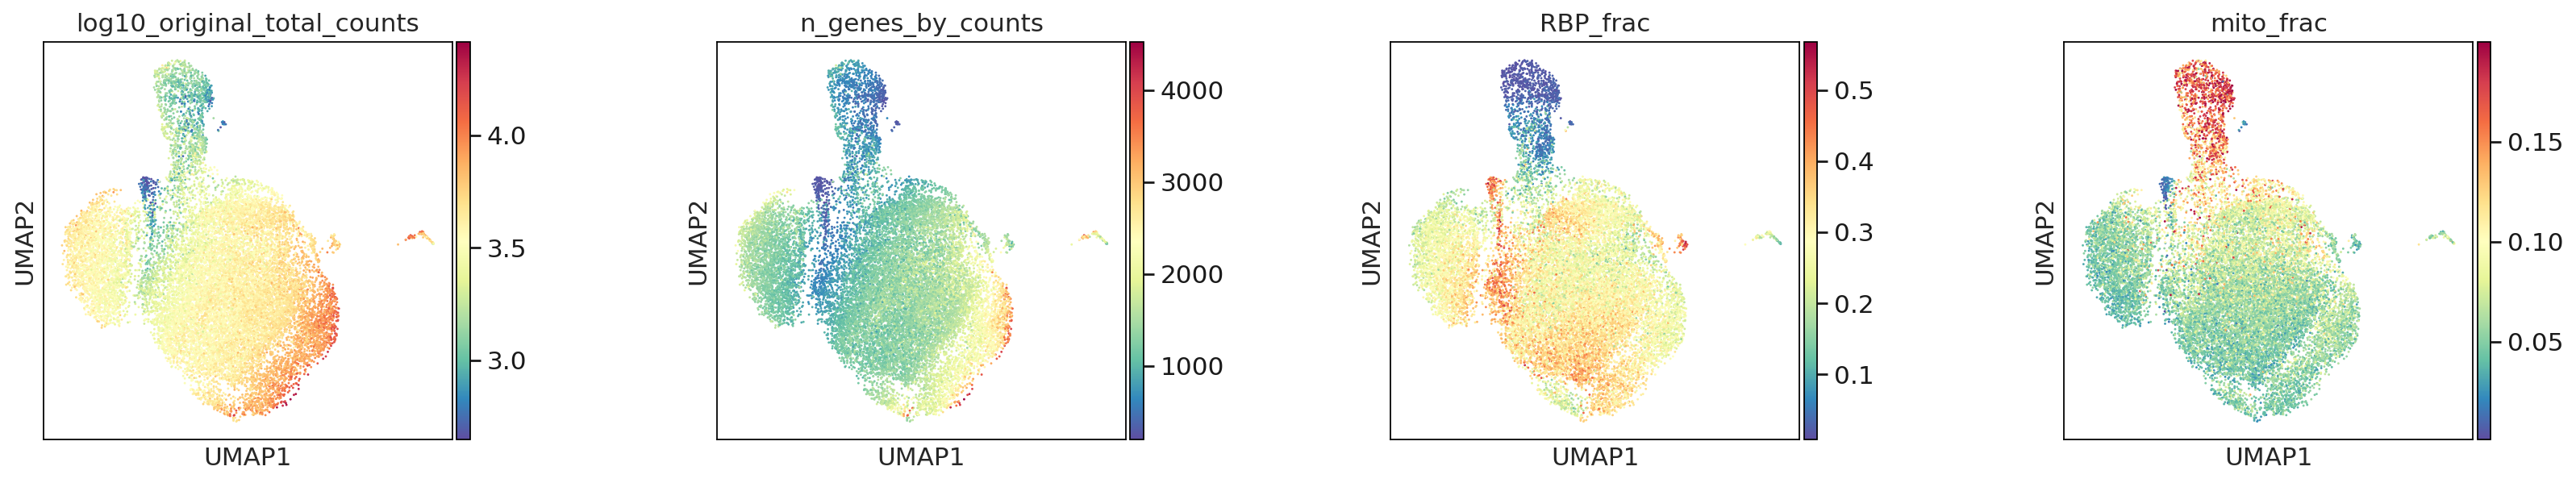

In [33]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
sc.pl.umap(
    adata, 
    color=['log10_original_total_counts', 'n_genes_by_counts','RBP_frac', 'mito_frac'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.5,
    sort_order = False
)

In [34]:
adata.shape

(18180, 18088)

Choose which clusters you want to remove, and add them to the list clusters_to_remove below.

In [39]:
clusters_to_remove = [7,  9, 11, 12, 16]
cluster_filter = [x not in clusters_to_remove for x in adata.obs['PhenoGraph_clusters']]
print('Total number of cells pre-filtering: ' + str(adata.shape[0]))
print('Number of cells to keep after filtering: ' + str(sum(cluster_filter)))
adata_filtered = adata[cluster_filter]

Total number of cells pre-filtering: 18180
Number of cells to keep after filtering: 15054


Check if the right clusters were removed.

Trying to set attribute `.uns` of view, copying.


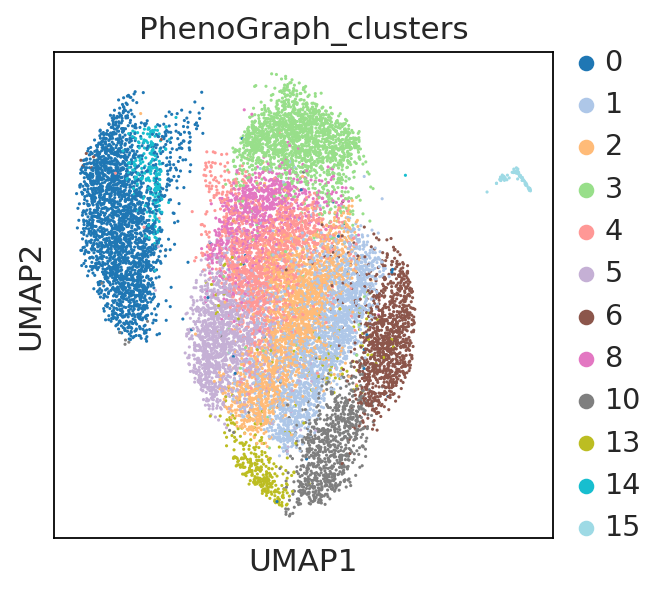

In [40]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
sc.pl.umap(
    adata_filtered, 
    color=['PhenoGraph_clusters'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.5,
    sort_order = False
)

If the right clusters and doublets were removed continue in the next line to store the result in your adata object.

In [41]:
adata = adata_filtered

In [42]:
adata.shape

(15054, 18088)

### Filtering out cells: doublets and contaminants

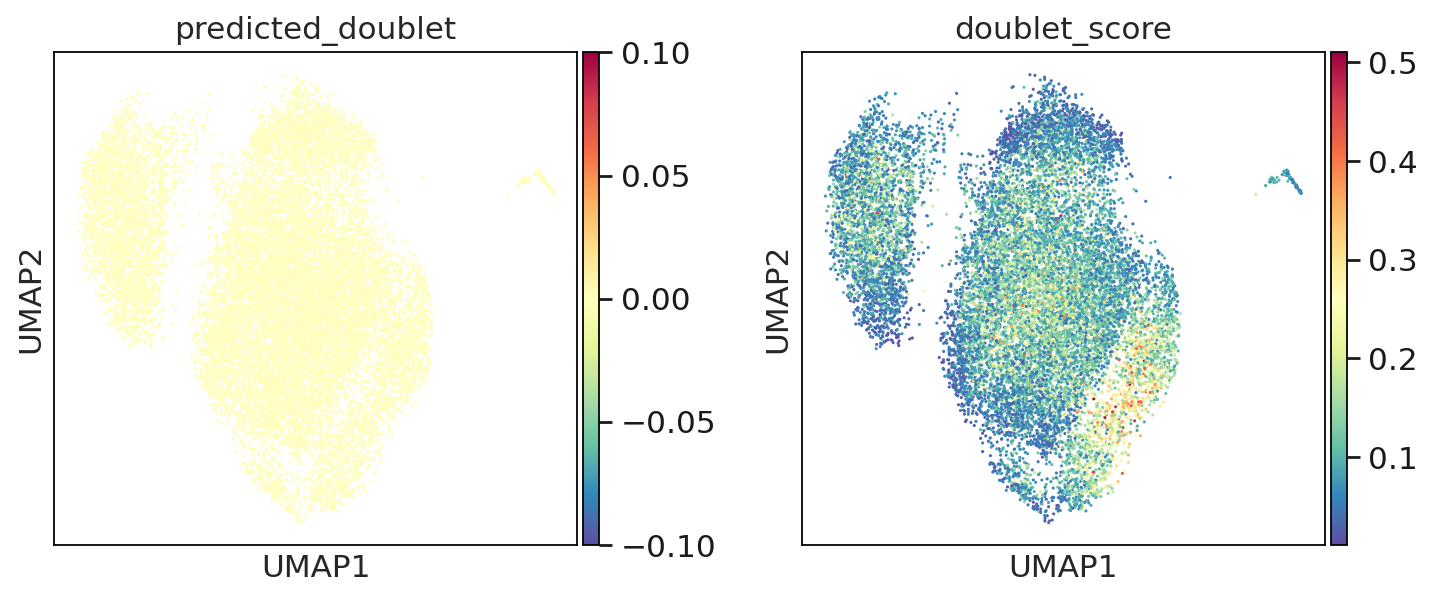

In [43]:
sc.pl.umap(
    adata_filtered, 
    color=['predicted_doublet', 'doublet_score'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

This would be also a good spot to remove the doublets you have identified above or any other cell population that does not match your experimental strategy

In [44]:
adata = adata[adata.obs['predicted_doublet'] == False]

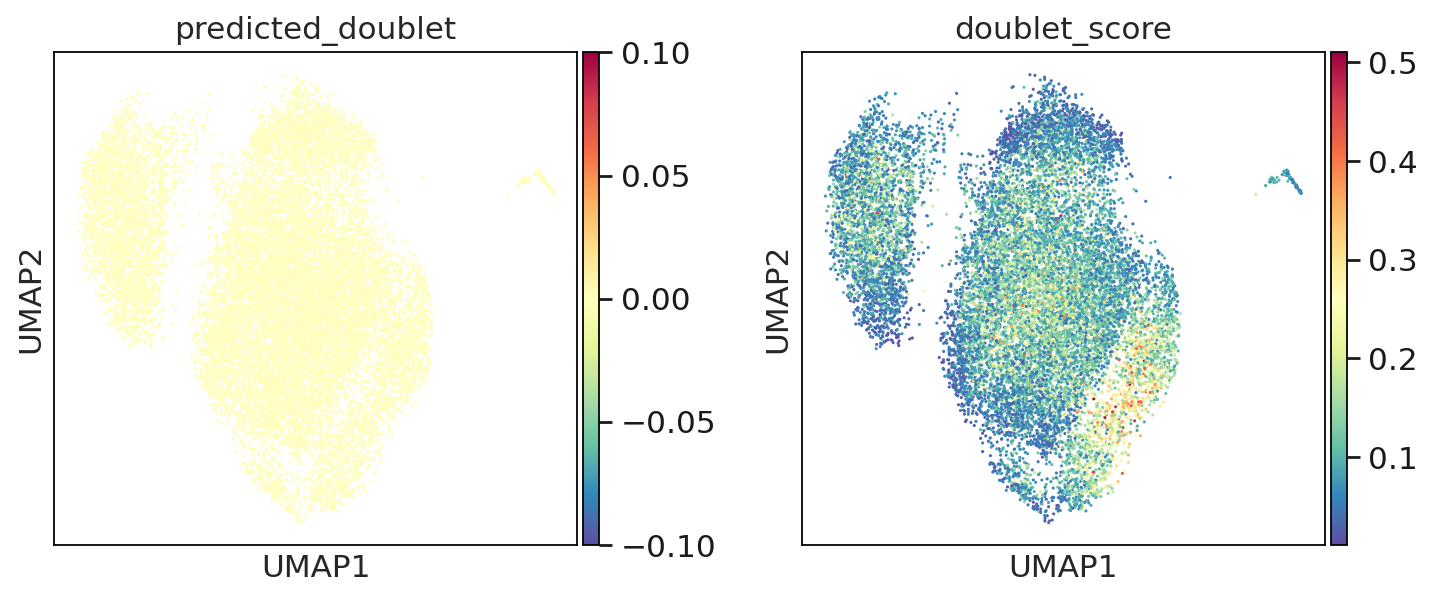

In [45]:
sc.pl.umap(
    adata, 
    color=['predicted_doublet', 'doublet_score'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

Let's now inspect if the right number of doublet cells has been removed from the dataset.

In [46]:
adata.shape

(15054, 18088)

### Reanalyze data after removal of cells

Once we have removed all unwanted cells, we need to reanalyze our data in a similar way to steps 4 and 5. 

In [47]:
rng = np.random.RandomState(42)
adata = sc.tl.pca(adata, n_comps=200, copy = True, svd_solver='arpack', random_state=rng)

<function matplotlib.pyplot.show(close=None, block=None)>

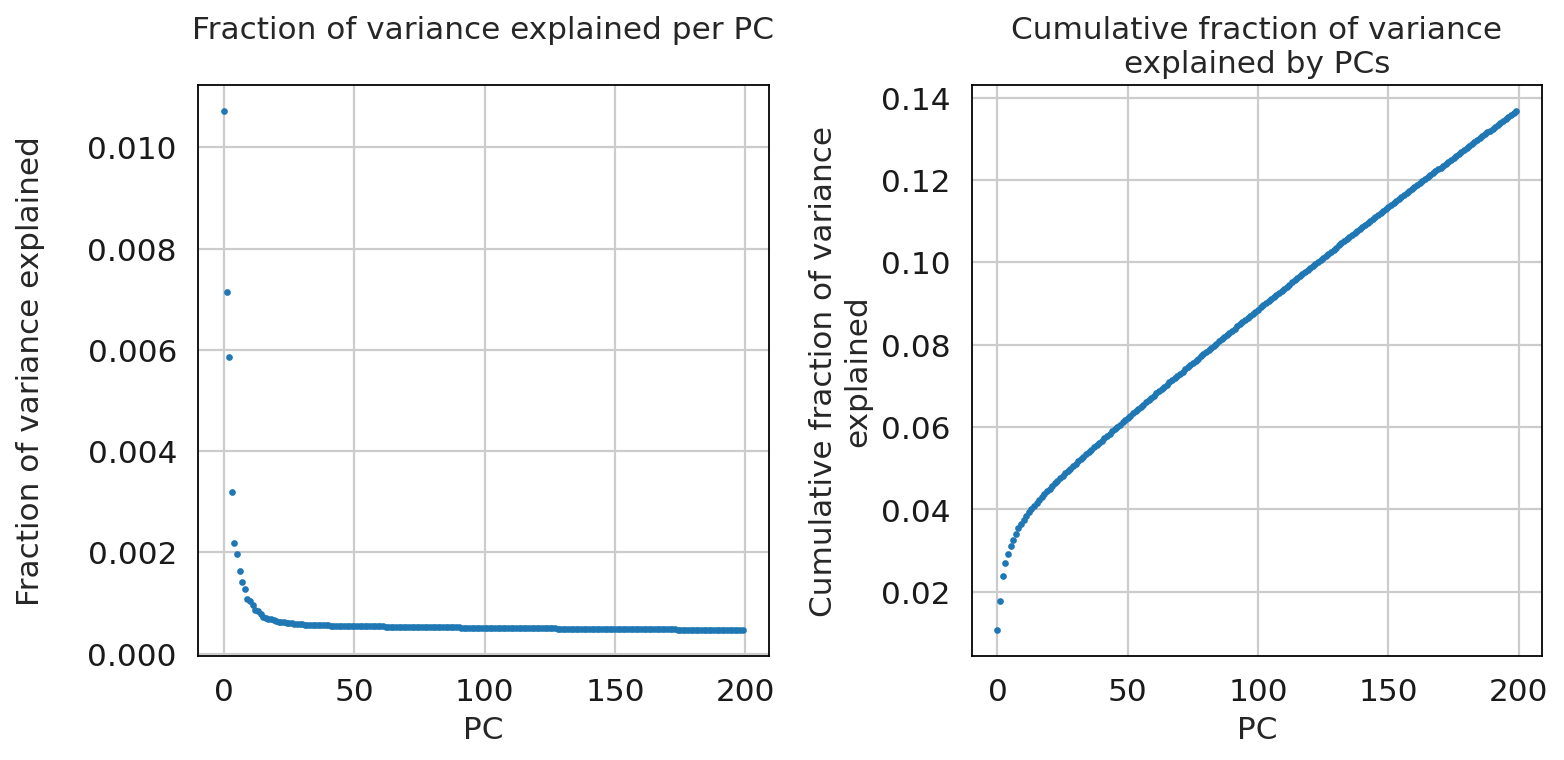

In [48]:
observe_variance(adata)

🕹️ Remember to choose a different number of principal components based on the re-analysis

In [49]:
rng = np.random.RandomState(42)
sc.tl.pca(adata, n_comps=30, svd_solver='arpack', random_state=rng)

In [50]:
sc.pp.neighbors(adata, n_neighbors=15)

In [51]:
sc.tl.umap(adata)

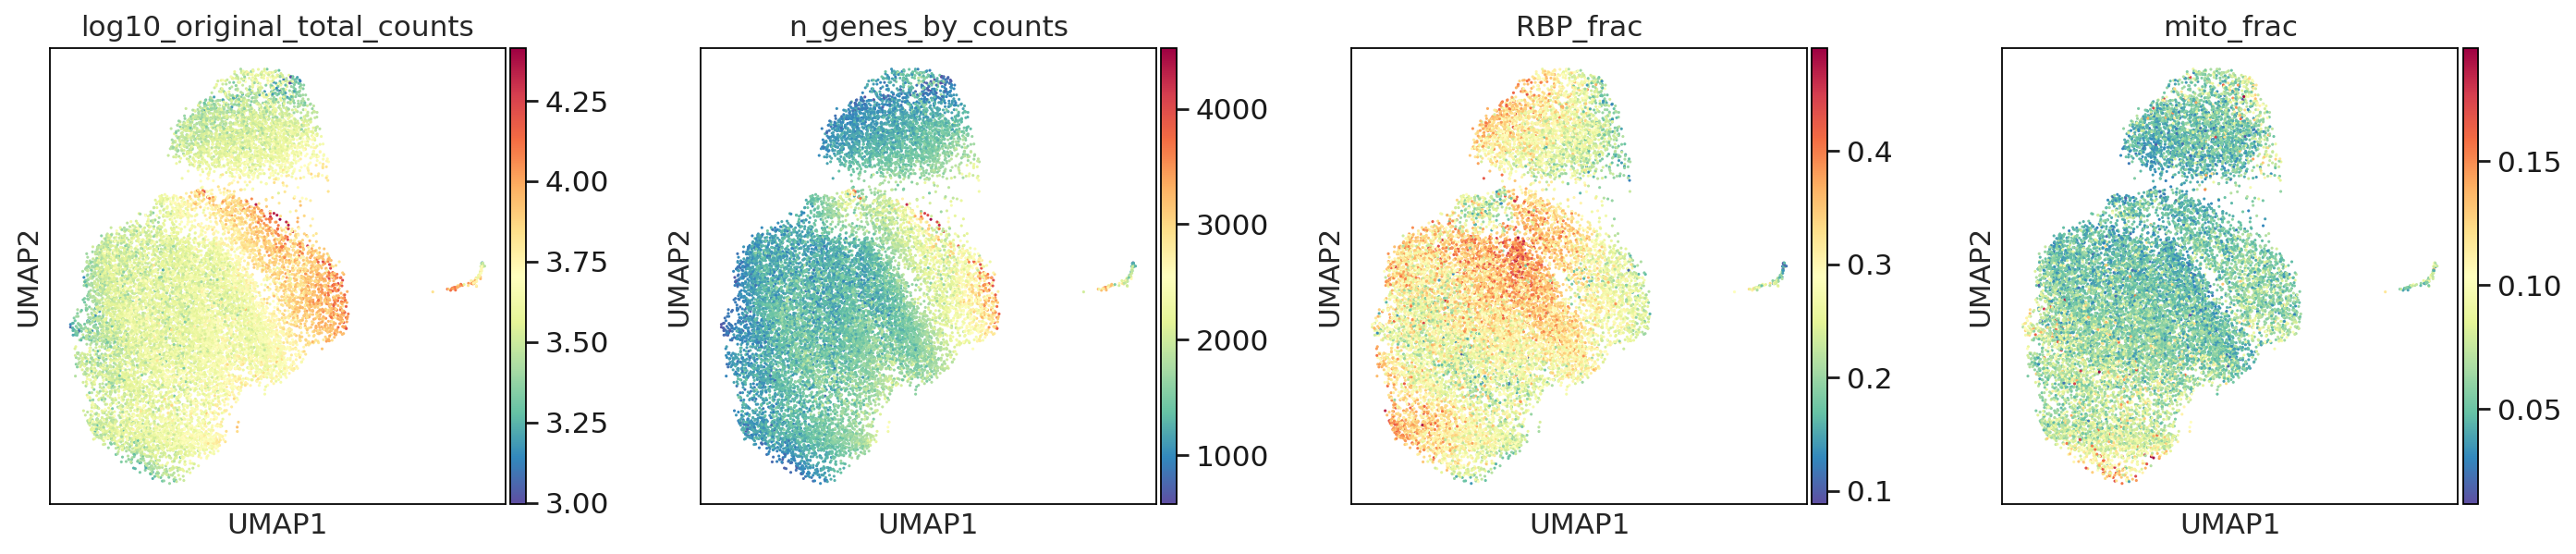

In [52]:
sc.pl.umap(
    adata, 
    color=['log10_original_total_counts', 'n_genes_by_counts','RBP_frac', 'mito_frac'], 
    palette='tab20', 
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

You are done! Just save you file and save the index of you cells. You can now come back to this dataset at anytime.

PS. For more visualization options check the scanpy tutorials.

In [55]:
path_to_h5ad = '/home/kousaa/scRNAseq-analysis/[AK011] Hana_unconvencional-Tcells/notebooks/files/Vd2_patients.h5ad'

In [56]:
adata.write(path_to_h5ad)

In [ ]:
adata = sc.read_h5ad(path_to_h5ad)

In [57]:
# save index of your good quality cells for future use
QCpassed_cells = adata.obs.index
QCpassed_cellsDF = pd.DataFrame(QCpassed_cells)
QCpassed_cellsDF.to_pickle('files/Vd2_patients_QCpassed.pkl')

In [58]:
QCpassed_cells.shape

(15054,)

In [59]:
%load_ext watermark

In [60]:
%watermark

Last updated: 2021-11-10T07:27:07.971469-05:00

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.29.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 3.10.0-957.12.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 72
Architecture: 64bit

